In [2]:
import os
import glob
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.io import MemoryFile

In [ ]:
# FUNCIONES
def recortar_dataset(dataset, geometria):
    out_image, out_transform = mask(dataset, geometria, crop=True)
    return out_image, out_transform
    """
    out_image: Es un numpy.ndarray. Una matriz pura de números. Aquí ya no hay "latitud/longitud", solo hay filas y columnas de valores (0 a 10000).
    out_transform: Es un objeto Affine; Es una fórmula matemática de 6 números que le dice al computador cómo convertir "Fila/Columna" a "Latitud/Longitud".

    """
def procesar_sentinel(ruta_safe_folder, geojson_crudo):
    """
    Args:
        ruta_safe_folder (str): Ruta a la carpeta .SAFE
        geojson_crudo (GeoDataFrame): El mapa cargado directamnete del archivo (sin reproyectar)
    """
    
    # 1. & 2. Búsqueda de Archivos

    """
    En Windows las carpetas se separan con \ (barra invertida).
    En Linux/Mac/Colab se separan con / (barra normal).
    Si se escribe "GRANULE/IMG_DATA" a mano, el código explota en Windows.
    os.path.join pone la barra correcta automáticamente.
    """
    base_granule = os.path.join(ruta_safe_folder, "GRANULE")
    
    if not os.path.exists(base_granule):
        print(" Error: No existe carpeta GRANULE")
        return None, None, None

    subcarpetas = glob.glob(os.path.join(base_granule, "L2A*"))
    if not subcarpetas:
        print("Error: No hay carpetas L2A")
        return None, None, None
        
    granule_dir = subcarpetas[0]
    """
    No sabemos la fecha exacta del archivo (ej. 20200220...).
    El * significa "cualquier texto"
    """
    path_b03_pattern = os.path.join(granule_dir, "IMG_DATA", "R10m", "*B03_10m.jp2")
    path_b11_pattern = os.path.join(granule_dir, "IMG_DATA", "R20m", "*B11_20m.jp2")
    
    """
    glob siempre devuelve una lista (porque podría haber 5 archivos que coincidan).
    Como sabemos que solo hay uno, tomamos el primero ([0])
    """
    try:
        path_b03 = glob.glob(path_b03_pattern)[0]
        path_b11 = glob.glob(path_b11_pattern)[0]
    except IndexError:
        print("Error: Archivos .jp2 no encontrados")
        return None, None, None

    print(f"Procesando: {os.path.basename(ruta_safe_folder)}")

    
    # 3. Abrimos la Banda Verde
    with rasterio.open(path_b03) as src_green:
        
        # 4. REPROYECCIÓN AUTOMÁTICA
        # Leemos el CRS de la imagen y convertimos el mapa 
        aoi_reproyectado = geojson_crudo.to_crs(src_green.crs)
        """
        Los datos de la columna "geometry" se reescribieron matemáticamente.
        Antes decían: (-73.1, -50.4) (Grados).
        Ahora dicen: (640000, 4400000) (Metros)
        """
        geometria_lista = aoi_reproyectado.geometry # Devuelve GeoSeries , el atributo de la geometría
        
        # 5. Recortamos Verde
        green_crop, green_transform = recortar_dataset(src_green, geometria_lista)
        
        # Guardamos referencias
        ref_height = src_green.height
        ref_width = src_green.width
        ref_crs = src_green.crs
        ref_transform = src_green.transform
        
        meta_final = src_green.meta.copy()
        meta_final.update({
            "driver": "GTiff", #Es el formato estándar mundial para guardar mapas. Es como un .tif de imagen normal, pero tiene las coordenadas GPS dentro del archivo.
            "height": green_crop.shape[1],
            "width": green_crop.shape[2],
            "transform": green_transform
        })

    # 6. Procesar Banda SWIR
    with rasterio.open(path_b11) as src_swir:
        swir_upsampled = src_swir.read( #La matriz perdió sus coordenadas GPS.
            1,
            out_shape=(ref_height, ref_width),
            resampling=Resampling.bilinear
            #Nearest: Rellenar huecos copiando el color de al lado (queda cuadriculado).
            #Bilinear: Rellenar huecos calculando el promedio de los vecinos (queda suave). Para nieve/glaciares, suave es mejor.
        )
        
        """
        La función mask (recortar) solo acepta archivos georeferenciados,
        no acepta simples matrices de números (arrays).
        La variable swir_upsampled es solo una lista de números.
        Creamos un MemoryFile. Es un archivo falso que vive en la RAM. 
        """
        with MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=ref_height,
                width=ref_width,
                count=1,
                dtype=swir_upsampled.dtype,
                crs=ref_crs,
                transform=ref_transform, #Le pegamos la etiqueta de GPS de la banda verde 
            ) as dataset_fantasma:
                dataset_fantasma.write(swir_upsampled, 1) #Le metemos los datos
                swir_crop, _ = recortar_dataset(dataset_fantasma, geometria_lista)

    return green_crop, swir_crop, meta_final

def calcular_ndsi(green_array, swir_array):
    """Calcula el índice de nieve manejando errores de división"""
    # Convertir a float
    g = green_array[0].astype('float32')
    s = swir_array[0].astype('float32')
    
    # Ignorar errores de división por cero
    np.seterr(divide='ignore', invalid='ignore')
    
    # Fórmula NDSI
    ndsi = (g - s) / (g + s)
    
    # Limpiar NaNs (donde la suma es 0)
    ndsi[np.isnan(ndsi)] = -1 # Poner fondo negro/tierra
    
    return ndsi

In [ ]:
# Configuración y datos
#Ruta a carpetas .SAFE
ruta_2020 = r"C:\Users\Fernanda\Desktop\Proyecto Glaciar\data\raw\S2A_MSIL2A_20200220T142651_N0500_R053_T18FXK_20230613T021157.SAFE"
ruta_2025 = r"C:\Users\Fernanda\Desktop\Proyecto Glaciar\data\raw\S2C_MSIL2A_20250322T141811_N0511_R010_T18FXK_20250322T203514.SAFE"# 2. ¡Magia!

# Ruta GeoJSON
AOI_path = 'data/map.geojson'
raw_aoi = gpd.read_file(AOI_path) #Esto es un GeoDataFrame


In [5]:
# Ejecución
print("PROCESANDO AÑO 2020")
verde_20, swir_20, meta_20 = procesar_sentinel(ruta_2020, raw_aoi)
ndsi_20 = calcular_ndsi(verde_20, swir_20)

print("\nPROCESANDO AÑO 2025")
verde_25, swir_25, meta_25 = procesar_sentinel(ruta_2025, raw_aoi)
ndsi_25 = calcular_ndsi(verde_25, swir_25)

PROCESANDO AÑO 2020
Procesando: S2A_MSIL2A_20200220T142651_N0500_R053_T18FXK_20230613T021157.SAFE

PROCESANDO AÑO 2025
Procesando: S2C_MSIL2A_20250322T141811_N0511_R010_T18FXK_20250322T203514.SAFE


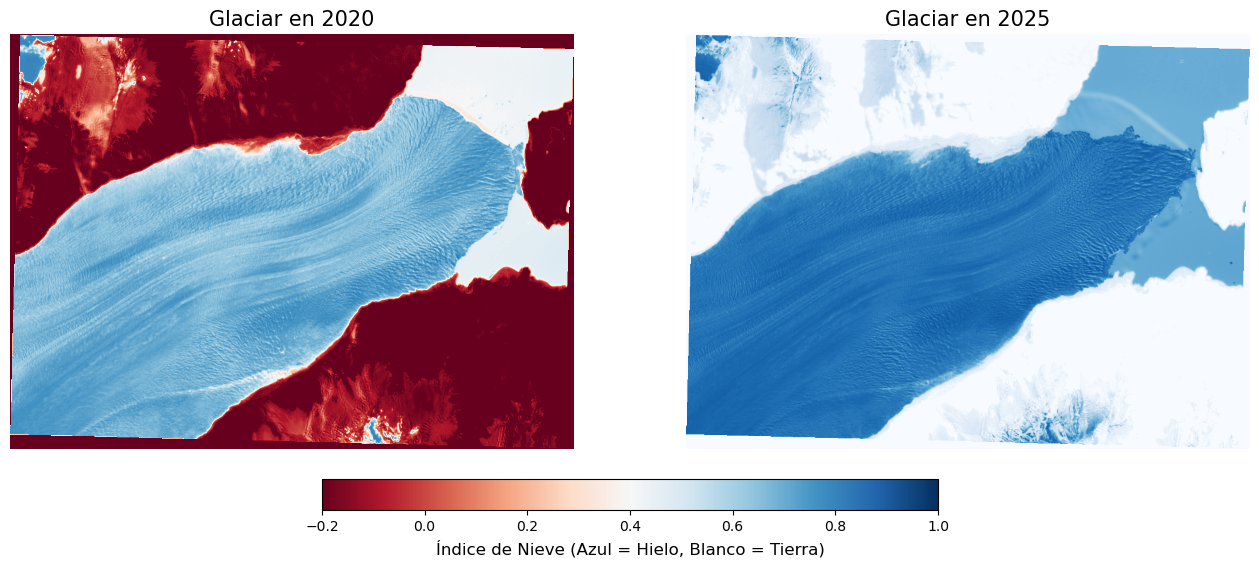

In [16]:
# Resultados visuales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Mapa 2020
im1 = ax1.imshow(ndsi_20, cmap='RdBu', vmin=-0.2, vmax=1)
ax1.set_title("Glaciar en 2020", fontsize=15)
ax1.axis('off')

# Mapa 2025
im2 = ax2.imshow(ndsi_25, cmap='Blues', vmin=-0.2, vmax=1)
ax2.set_title("Glaciar en 2025", fontsize=15)
ax2.axis('off')

# Barra de color
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Índice de Nieve (Azul = Hielo, Blanco = Tierra)', fontsize=12)

plt.show()
